# OBJECT DETECTION IA 
## (Classification only -> No localisation) 
### DeepLearning Network using CNN transfert learning with a classifier that I had
### The goal is to detect human body in a video-surveillance cam

# DATA
## Import

In [157]:
%matplotlib inline
from matplotlib import pyplot as plt

import torch
from torchvision import datasets, transforms

import helper #pymodule that I add to print image from dataloader

## Download 
###### Do not re-execute this cell

In [6]:
#DO NOT RE-EXECUTE THIS CELL

#Download kaggle dataset
!kaggle datasets download -p "data/raw" --unzip --force constantinwerner/human-detection-dataset/version/3



^C


## Transform & LOAD data
we doesn't have to transform much the data, all images are already 256*256 px

In [81]:
data_dir = "data/kaggle_ConstantinWerner"

#transform
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                #transforms.Grayscale(),
                                transforms.ToTensor()])
#maybe add normalisation -> transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]) 
                                                            

#load (with ImageFolder)
train_dataset = datasets.ImageFolder(data_dir + "/train", transform=transform)
test_dataset = datasets.ImageFolder(data_dir + "/test", transforms.ToTensor())

images type :  torch.Size([20, 3, 256, 256])
labels type :  torch.Size([20])


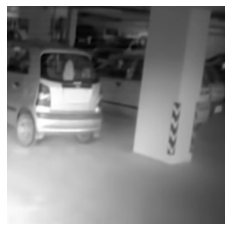

In [82]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)
                                              

images, labels = next(iter(train_dataloader))

helper.imshow(images[2], normalize=False)

print("images type : ", images.shape)
print("labels type : ", labels.shape)

# MODEL

## Import

In [118]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

from collections import OrderedDict

## Load pretrained model

In [119]:
model = models.densenet121(pretrained=True)

## Create classifier

In [120]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024,512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2',nn.Linear(512,2)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

criterion = nn.NLLLoss()

## Train model
### Pre-train

In [124]:
#GPU available ?
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Train on GPU")
else:
    device = torch.device("cpu")
    print("Train on CPU")
    

#Freeze model parameters (not classifier parameters) (transfert learning)
#Possibly don't freeze last layer parameters ? State of last(s) layer: freeze
for param in model.parameters():
    param.requires_grad = False

#Add our classifier to our pretrained network
model.classifier = classifier

#move model on the right device
model.to(device)

#Activate grad (udaptabilty) for the classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

#optimizer
optimizer = optim.SGD(model.parameters(), lr=0.05) 

#training mode
model.train()

Train on GPU


### Train
We have : train_dataloader & test_dataloader  

In [125]:
epochs = 10

for e in range(epochs):
    epoch_loss = 0
    for images, labels in train_dataloader:
        
        optimizer.zero_grad() #delete gradients of the last backward pass
        
        images,labels = images.to(device), labels.to(device) #move tensors in gpu if available
        
        output = model.forward(images) #forward pass
        
        loss = criterion(output, labels) #calculate loss
        
        loss.backward()   #calculate gradient of the loss function
        
        optimizer.step()  #update weights (using gradients)
        
        epoch_loss += loss.item()
        
    print("epoch ",epochs, " -> loss = ", epoch_loss)
print("Train over !")      


epoch  10  -> loss =  14.325010597705841
epoch  10  -> loss =  9.32982224225998
epoch  10  -> loss =  8.36965149641037
epoch  10  -> loss =  8.235970743000507
epoch  10  -> loss =  7.231369882822037
epoch  10  -> loss =  5.1524461433291435
epoch  10  -> loss =  6.076810959726572
epoch  10  -> loss =  4.13945659995079
epoch  10  -> loss =  5.564956247806549
epoch  10  -> loss =  4.868168547749519
Train over !


## TEST MODEL
### Accuracy test (on the whole test_dataset)

In [363]:
model.eval()

accuracy = 0
i = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        proba = torch.exp(output)


        top_p, top_class = proba.topk(1, dim=1)
        equal = top_class == labels.view(*top_class.shape)

        i+=1
        accuracy += torch.sum(equal).item()
    print("accuracy =",(accuracy/(len(test_dataloader.dataset)))*100,"%")

accuracy = 92.0 %


### Test visualisation

It's a human at  0.13 %


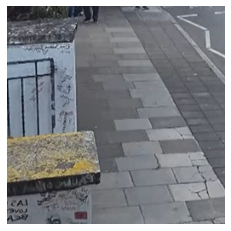

In [370]:
model.eval()

images, labels = next(iter(test_dataloader))
helper.imshow(images[i].cpu(), normalize=False)


images = images.to(device)
labels = labels.to(device)



    
   
with torch.no_grad():
    output =  model.forward(images)
    proba = torch.exp(output)
    
print("It's a human at ", round(proba[i,0].item(),2), "%")

    

## Saving model on demand

In [372]:
#DON'T FORGOT TU NAME YOUR MODEL
model_name = "YOUR_MODEL_NAME"
torch.save(model.state_dict(), "trained_models/" + model_name)